# Introduction to Networkx

`Networkx` (typically imported as `nx`) is one of the most common Python packages for working with network data. You can find the [documentation here](https://networkx.org/documentation/stable/index.html). To get us started here are some networkx basics:

In [1]:
# import the networkx package
import networkx as nx

In [2]:
# create an empty, undirected network 
G = nx.Graph()

In [3]:
# add a node
G.add_node('a')
print(G.nodes())

['a']


In [4]:
# add an edge, this will automatically add missing nodes
G.add_edge('b', 'c')
print(G.nodes())
print(G.edges())

['a', 'b', 'c']
[('b', 'c')]


In [5]:
# add an edge with weight
G.add_edge('a', 'c', weight=1)

# to access edge (or node) attributes, you need to set data=True. Eg:
print('Just the node-node pairs:')
print(G.edges())

print('\nSetting data=True to get edge attributes')
print(G.edges(data=True))

Just the node-node pairs:
[('a', 'c'), ('b', 'c')]

Setting data=True to get edge attributes
[('a', 'c', {'weight': 1}), ('b', 'c', {})]


For edges where the weight is specified, we can access that using using the nodes and attribute name as keys. In an undirected network, it doesn't matter which order you put the node-keys in:

In [6]:
print(G['a']['c']['weight'])
print(G['c']['a']['weight'])

1
1


Note that we didn't specify a weight when we added the edge `b - c`. By default, no attributes are specified, so we can't access the "weight" of this edge without adding "weight" as an attribute first. Eg, the following code with throw an error:

In [7]:
print(G['b']['c']['weight'])

KeyError: 'weight'

But, can use the dictionary method `.setdefault()` to ensure the attribute is added if we need to. More on dictionaries soon!

In [8]:
# increment weights
for i, j in G.edges():  # for every edge
    G[i][j].setdefault('weight', 0) # set the default weight to zero
    G[i][j]['weight'] += 1 # NOW every edge has a weight so we can do things with it
    
print(G.edges(data=True)) # print with weights

[('a', 'c', {'weight': 2}), ('b', 'c', {'weight': 1})]


Note: You can add arbitrary node or edge attributes. There is no set list of attribute names you have to draw from. Attributes can be a range of types.

In [9]:
# add attributes to existing nodes
nx.set_node_attributes(G, values={'a': [1, 2, 3]}, name='records')
nx.set_node_attributes(G, values={'b': 1}, name='count')
nx.set_node_attributes(G, values={'c': 'sunny'}, name='weather')

print(G.nodes(data=True))

[('a', {'records': [1, 2, 3]}), ('b', {'count': 1}), ('c', {'weather': 'sunny'})]


# Text and Networks
# Example 1: Hashtag co-occurance

Nodes are the hashtags which appear in a given set of tweets. Edges represent if two hashtags co-occur in the same tweet. Weight of edge indicates number of times they co-occur.

In [10]:
# packages we will need for this example
import json # loading data
import networkx as nx # for networks!
import numpy as np # for math
import itertools as it # fancy iteration
import matplotlib.pyplot as plt # visualizations

In [11]:
filename = 'tweets.json'

with open(filename, 'r') as fp:
    tweets = json.loads(fp.read())
    
print('{} tweets loaded'.format(len(tweets)))

599668 tweets loaded


## Data format and background
These tweets were collected from the Twitter API using a list of "Black Lives Matter" related keywords. All tweets were made between in April and May of 2021. The dataset has already been trimmed to only include tweets with at least one hashtag. All collected tweets were public on Twitter at the time of data collection. Content warning: no additional filtering has been done and the dataset may include vile and offensive language.

**Data Format** The Twitter API returns objects in JSON format. Here, using `json.loads()` reads the data into the object `tweets`, which is a list of **dictionary** objects. This data format has a key, value format -- eg, keys are used to "look up" values in the dictionary. In other words, if we were to print out `tweets` it would be a list that would look something like this:
```
tweets = [{tweet 1 dictionary},
          {tweet 2 dictionary},
          ...
          {tweet n dictionary}
          ]
```

Since `tweets` is a list, we can find out how many tweets it contains using `len()` (eg, equivalent of "length" for R users). We can access a specific tweet using it's index (Note: the first element is at index 0). or by iterating over the list (eg: `for tweet in tweets:`).

Let's look at the first tweet in the dataset:

In [12]:
tweets[0]

{'text': '@MrAndyNgo But #BLM is all about peace according to @VP.',
 'entities': {'hashtags': [{'start': 15, 'end': 19, 'tag': 'BLM'}],
  'mentions': [{'start': 0, 'end': 10, 'username': 'MrAndyNgo'},
   {'start': 52, 'end': 55, 'username': 'VP'}]},
 'context_annotations': [{'domain': {'id': '10',
    'name': 'Person',
    'description': 'Named people in the world like Nelson Mandela'},
   'entity': {'id': '875006493984149509',
    'name': 'Kamala Harris',
    'description': 'US Senator Kamala Harris (CA)'}},
  {'domain': {'id': '10',
    'name': 'Person',
    'description': 'Named people in the world like Nelson Mandela'},
   'entity': {'id': '1161294453560098822', 'name': 'Andy Ngo'}},
  {'domain': {'id': '35',
    'name': 'Politician',
    'description': 'Politicians in the world, like Joe Biden'},
   'entity': {'id': '875006493984149509',
    'name': 'Kamala Harris',
    'description': 'US Senator Kamala Harris (CA)'}}],
 'public_metrics': {'retweet_count': 1,
  'reply_count': 0,


Here, we see that each tweet dictionary contains a lot of information about the tweet, which is all contained in nested dictionary objects. We can use `[key]` to access a given key-value pair (where the value may be a dictionary!) and we can use `.keys()` to see all available keys. Eg, the top-level keys available for this tweet are:

In [13]:
tweet = tweets[0] # save this as tweet of interest
tweet.keys()

dict_keys(['text', 'entities', 'context_annotations', 'public_metrics', 'author_id', 'id', 'in_reply_to_user_id', 'created_at', 'lang', 'referenced_tweets', 'conversation_id'])

While we could work directly with the `text` Twitter makes hashtag analysis particularly easy by indentifying the specific hashtags which exist in the tweet. Note that field *only* stores items which were explicitly denoted as hashtags (using '#'). Eg, given the text:

```
The hashtag for BLM is #BLM
```
Only the second reference of BLM will count as a hashtag. Something to think about if you're working with Twitter data: **which string do you want to be considered as nodes?**

Hashtags included in a tweets are stored under entities -> hashtags. Hashtags will be stored in a list with a record of the tag itself and where it appears in the tweet. Eg:

In [14]:
tweet['entities']['hashtags']

[{'start': 15, 'end': 19, 'tag': 'BLM'}]

In [15]:
# start : 15 and end : 19 are tell you exactly where the hashtag can be found in the tweet:
tweet['text'][15:19]

'#BLM'

In [16]:
# can extract just the 'tag' information using a list comprehension:
tag_details = tweet['entities']['hashtags']  

# only key the 'tag' part of each hashtag
hashtags = [details['tag'] for details in tag_details]

print(hashtags)

['BLM']


We can also retrieve hashtags "the old fashioned way" by iterating over word in the tweet and looking for words that start with the '#' symbol. 

Note that in Python `split()` can be used to split a string into a list, similar to the R function strsplit(tweet, " "). By default, `split()` will split on spaces, but you can pass any character/collection of characters, eg `split(',')` or `split(' and ')`.

In [17]:
# just show spliting the string and iterating over each word
for word in tweet['text'].split():
    print(word)

@MrAndyNgo
But
#BLM
is
all
about
peace
according
to
@VP.


In [18]:
# get hashtags

hashtags = list() # empty list to store hashtags

for word in tweet['text'].split(): # iterate over each word
    if word[0] == '#': # if the 0-index element is #
        hashtags.append(word) # keep it as a hashtag
        
print(hashtags)

['#BLM']


## Making a network
To turn this into a hashtag co-occurance network we need to iterate through every tweet, saving every hashtag as a node and saving an edge between every pair of hashtags. If we see a hashtag pair more than once, we'll increase the weight of that edge.

We'll store our network data using `Networkx` (which we've imported as `nx`). You can find the [documentation here](https://networkx.org/documentation/stable/index.html).

In [20]:
G = nx.Graph() # init empty network

for tweet in tweets: # iterate over all tweets
    
    # note: all tweets in this dataset have hashtags
    tag_details = tweet['entities']['hashtags']  
    
    # only key the 'tag' part of each hashtag
    hashtags = [details['tag'] for details in tag_details]
    
    # if there's only 1 hashtag, we have a node but no edge
    if len(hashtags) == 1:
        h1 = hashtags[0]
        G.add_node(h1) # add node (won't replace)
        G.nodes[h1].setdefault('count', 0)
        G.nodes[h1]['count'] += 1
        
    else:
        for h1, h2 in it.combinations(hashtags, 2):
            G.add_edge(h1, h2)
            G[h1][h2].setdefault('weight', 0)
            G[h1][h2]['weight'] += 1
            
            G.nodes[h1].setdefault('count', 0)
            G.nodes[h1]['count'] += 1
            
            G.nodes[h2].setdefault('count', 0)
            G.nodes[h2]['count'] += 1
            
print('{} nodes (hashtags) found'.format(len(G)))

159312 nodes (hashtags) found


### Sample analysis

In [21]:
# we can retrieve the weighted degree distribution using:
degrees = dict(G.degree(weight='weight'))

# this will return a dictionary where the keys are hashtags and the values are the degree

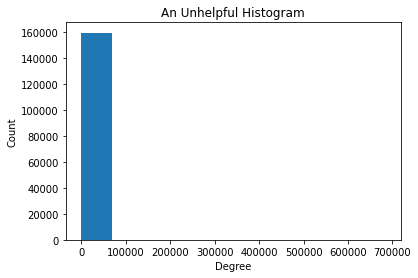

In [22]:
# Many networks have a heavy tailed degree distribution, which makes typical histograms not very helpful

plt.hist(degrees.values())
plt.xlabel('Degree')
plt.ylabel('Count')
plt.title('An Unhelpful Histogram')
plt.show()

In [23]:
# instead, will bin our data and look at it on log-log plot

# first, a function for binning our data

def binning(data,nb=50,log=True):
    # Seperate a vector of data into linear or log bins

    # Input:
    #   data : a vector of data
    #   bins : the number of bins to output (default: 50) 
    #   log : whether to log bin the data (default: True)

    # Output:
    #   x : the the midpoint of each bin
    #   y: the height of each bin 

    # coerce data to list
    data = list(data)
    
    # 1. find the data's upper and lower bounds
    lower_bound = min(data)
    upper_bound = max(data) + 1

    # 2. Define bins
    if log:
        lower_bound = np.log10(lower_bound) if lower_bound > 0 else 0
        upper_bound = np.log10(upper_bound)
        bins = np.logspace(lower_bound, upper_bound, nb)

    else:
        bins = np.linspace(lower_bound, upper_bound, nb)
    
    # 3. Compute the midpoint of each bin
    x = bins[1:] - np.diff(bins) / 2.0 

    # 4. Compute the height of each bin
    y, __ = np.histogram(data, 
                         weights=np.ones(len(data))/len(data),
                         bins = bins, 
                         density=False)

    return x, y

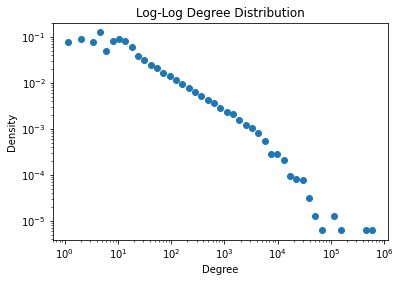

In [24]:
x, y = binning(degrees.values())

plt.loglog(x, y, marker='o', linewidth=0)
plt.xlabel('Degree')
plt.ylabel('Density')
plt.title('Log-Log Degree Distribution')
plt.show()

### Look at top hashtags

In [25]:
# the items in the degrees dictionary will be stored in arbitrary order

for i, (node, degree) in enumerate(degrees.items()):
    if i < 5:
        print(node, degree)

BLM 481299
MAKEABUELAGREATAGAIN 1
BlackLivesMatter 684418
PoliceBrutality 24905
DefundThePolice 23757


In [26]:
# we can sort this form highest to lowest using:
sorted_degrees = dict(sorted(dict(degrees).items(), key=lambda item: item[1], reverse=True))

for i, (node, degree) in enumerate(sorted_degrees.items()):
    if i < 10:
        print(node, degree)

BlackLivesMatter 684418
BLM 481299
blm 158577
blacklivesmatter 128101
GeorgeFloyd 101087
LGBTQ 63974
Resist 45536
racism 45069
DaunteWright 43429
FBR 41148


### Removing capitalization
What if we want "BLM" and "blm" to be the same node? We could adjust for this in our current network, but it's actually easier to just rebuild the network and force everything to be lower case

In [27]:
G = nx.Graph() # init empty network

for tweet in tweets: # iterate over all tweets
    
    # note: all tweets in this dataset have hashtags
    tag_details = tweet['entities']['hashtags']  
    
    ##### CHANGE: Make all hashtags lower case
    hashtags = [details['tag'].lower() for details in tag_details]
    
    #### NEW: Coerce to set (unique items) and then back to list
    # Preventsself loops based on different capitalization
    hashtags = list(set(hashtags))
    
    # if there's only 1 hashtag, we have a node but no edge
    if len(hashtags) == 1:
        h1 = hashtags[0]
        G.add_node(h1) # add node (won't replace)
        G.nodes[h1].setdefault('count', 0) 
        G.nodes[h1]['count'] += 1
        
    else:
        for h1, h2 in it.combinations(hashtags, 2):
            G.add_edge(h1, h2)
            G[h1][h2].setdefault('weight', 0)
            G[h1][h2]['weight'] += 1
            
            G.nodes[h1].setdefault('count', 0)
            G.nodes[h1]['count'] += 1
            
            G.nodes[h2].setdefault('count', 0)
            G.nodes[h2]['count'] += 1
            
print('{} nodes (hashtags) found'.format(len(G)))

130132 nodes (hashtags) found


In [28]:
# lets look at the top degrees again
degrees = dict(G.degree(weight='weight'))
sorted_degrees = dict(sorted(dict(degrees).items(), key=lambda item: item[1], reverse=True))

for i, (node, degree) in enumerate(sorted_degrees.items()):
    if i < 10:
        print(node, degree)

blacklivesmatter 812882
blm 622415
georgefloyd 113669
lgbtq 75081
racism 62891
resist 51431
antifa 48558
dauntewright 46828
biden 44569
alllivesmatter 43584


In [29]:
# make a subgraph with just the 50 highest degree nodes
top = list(sorted_degrees.keys())[:50]
sub = G.subgraph(top)

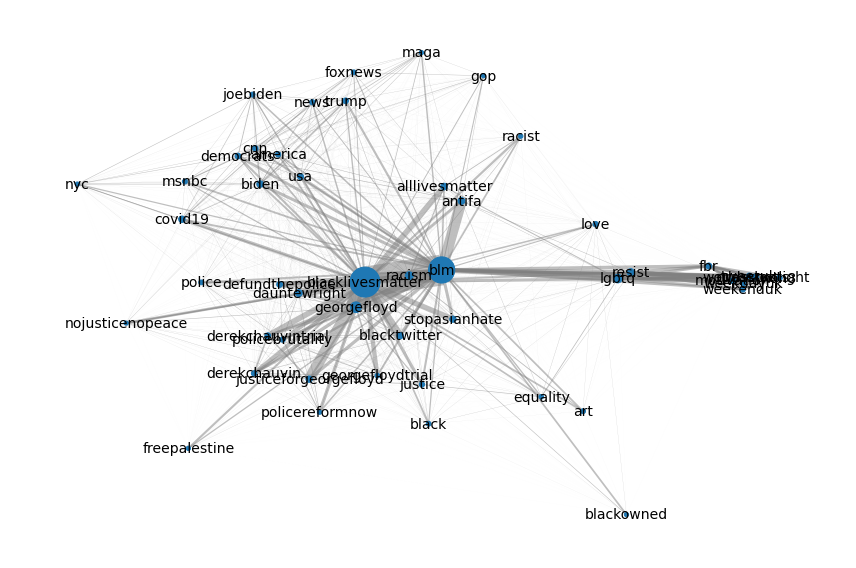

In [30]:
plt.figure(figsize=(12,8))
pos = nx.spring_layout(sub, seed=7) 

# nodes
counts = nx.get_node_attributes(G, 'count')
node_size = [counts[node]//10**3 for node in sub.nodes()]
nx.draw_networkx_nodes(sub, pos, node_size=node_size)

# edges
edge_width = [details['weight']/10**3 for i, j, details in sub.edges(data=True)]
nx.draw_networkx_edges(sub, pos, width=edge_width, 
                       edge_color='grey', alpha=0.5)


# labels
nx.draw_networkx_labels(sub, pos, 
                        font_size=14)

ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.tight_layout()
plt.show()

# Example 2: Named entities in congressional record

### Text processing and cleaning

In [87]:
# packages we will need for this example
import spacy # fancy text parsing
from bs4 import BeautifulSoup # for dealing with html
import networkx as nx # for networks
import numpy as np # for math
import itertools as it # fancy iteration
import matplotlib.pyplot as plt # visualizations

nlp = spacy.load('en_core_web_sm')

# for better performance use the large language model:
#nlp = spacy.load('en_core_web_lg')

In [32]:
filename = 'CREC-2020-06-11.txt'

with open(filename, 'r') as fp:
    raw_text = fp.read()

In [33]:
raw_text[:5000]

'<html>\n<head>\n<title>Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)</title>\n</head>\n<body><pre>\n[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]\n[House]\n[Page H2379]\nFrom the Congressional Record Online through the Government Publishing Office [<a href="https://www.gpo.gov">www.gpo.gov</a>]\n\n\n             H O U S E  O F  R E P R E S E N T A T I V E S\n\n\nVol. 166\n\n\nWASHINGTON, THURSDAY, JUNE 11, 2020\n\nNo. 108\n\n\n</pre></body>\n</html>\n<html>\n<head>\n<title>Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)</title>\n</head>\n<body><pre>\n[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]\n[House]\n[Page H2379]\nFrom the Congressional Record Online through the Government Publishing Office [<a href="https://www.gpo.gov">www.gpo.gov</a>]\n\n[[Page H2379]]\n\nHouse of Representatives\n\n  The House met at 9 a.m. and was called to order by the Speaker pro \ntempore (Mr. Brown of Maryland

In [34]:
# strip html tags using beautiful soup
clean = BeautifulSoup(raw_text, 'html.parser').text

clean[:1000]

'\n\nCongressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)\n\n\n[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]\n[House]\n[Page H2379]\nFrom the Congressional Record Online through the Government Publishing Office [www.gpo.gov]\n\n\n             H O U S E  O F  R E P R E S E N T A T I V E S\n\n\nVol. 166\n\n\nWASHINGTON, THURSDAY, JUNE 11, 2020\n\nNo. 108\n\n\n\n\n\n\nCongressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)\n\n\n[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]\n[House]\n[Page H2379]\nFrom the Congressional Record Online through the Government Publishing Office [www.gpo.gov]\n\n[[Page H2379]]\n\nHouse of Representatives\n\n  The House met at 9 a.m. and was called to order by the Speaker pro \ntempore (Mr. Brown of Maryland).\n\n                          ____________________\n\n\n\n\n\n\nCongressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)\n\n\n[Congressional Record Volume 166, Numb

In [35]:
# turn into a Spacy document
doc = nlp(clean)
print(doc)



Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)


[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]
[House]
[Page H2379]
From the Congressional Record Online through the Government Publishing Office [www.gpo.gov]


             H O U S E  O F  R E P R E S E N T A T I V E S


Vol. 166


WASHINGTON, THURSDAY, JUNE 11, 2020

No. 108






Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)


[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]
[House]
[Page H2379]
From the Congressional Record Online through the Government Publishing Office [www.gpo.gov]

[[Page H2379]]

House of Representatives

  The House met at 9 a.m. and was called to order by the Speaker pro 
tempore (Mr. Brown of Maryland).

                          ____________________






Congressional Record, Volume 166 Issue 108 (Thursday, June 11, 2020)


[Congressional Record Volume 166, Number 108 (Thursday, June 11, 2020)]
[House]
[Page H237

In [36]:
# 'doc' is now a spacy document
type(doc)

spacy.tokens.doc.Doc

SpaCy now stores this text as essentially a series of "tokens". Tokens are strings of arbitrary length that form a
"building block" of a given language. They can be words, punctuation, white space, etc

In [37]:
# print first 10 tokens 
# Tokens includes white space!
for i, token in enumerate(doc):
    if i < 10:
        print(token.text)




Congressional
Record
,
Volume
166
Issue
108
(
Thursday


In [38]:
# we can also see how many total tokens there are using len()
print('The doc has {} tokens'.format(len(doc)))

The doc has 31727 tokens


SpaCy also stores information about each of these tokens. You can see a list of all available token attributes [here](https://spacy.io/api/token#attributes). Here are a few core ones:
* token.text : string of token
* token.lower_ : lowercase form of the token
* token.lemma_ : base form of token 
* token.pos_ : coarse-grained part-of-speech from the [Universal POS tag set](https://universaldependencies.org/docs/u/pos/)
* token.tag_ : fine-grained part-of-speech
* token.sentiment : sentiment (use carefully!!)
* token.is_stop : boolean indicating if stop word
* token.is_digit : boolean indicating if digit
* token.vector : word embedding (length 300 vector)

In [39]:
for i, token in enumerate(doc):
    if i > 1000 and i < 1010:
        print(token.text)
        print('  index in document: ', token.i)
        print('  lemma: ', token.lemma_)
        print('  Part of speech: ', token.pos_)
        print('  Stop word?', token.is_stop)
        print()

.
  index in document:  1001
  lemma:  .
  Part of speech:  PUNCT
  Stop word? False

The
  index in document:  1002
  lemma:  the
  Part of speech:  DET
  Stop word? True

Chair
  index in document:  1003
  lemma:  Chair
  Part of speech:  PROPN
  Stop word? False

announces
  index in document:  1004
  lemma:  announce
  Part of speech:  VERB
  Stop word? False

the
  index in document:  1005
  lemma:  the
  Part of speech:  DET
  Stop word? True

Speaker
  index in document:  1006
  lemma:  Speaker
  Part of speech:  PROPN
  Stop word? False

's
  index in document:  1007
  lemma:  's
  Part of speech:  PART
  Stop word? True



  index in document:  1008
  lemma:  

  Part of speech:  SPACE
  Stop word? False

appointment
  index in document:  1009
  lemma:  appointment
  Part of speech:  NOUN
  Stop word? False



In [40]:
# recover token from index
doc[1009]

appointment

### Working with named entities

In [41]:
all_ents = doc.ents
print('{} entities found'.format(len(all_ents)))

3881 entities found


In [42]:
for ent in all_ents:
    print(ent.text, ent.label_)
    print('   starts at: {}, ends at: {}'.format(ent.start_char, ent.end_char))

166 CARDINAL
   starts at: 31, ends at: 34
Thursday, June 11, 2020 DATE
   starts at: 46, ends at: 69
166 CARDINAL
   starts at: 102, ends at: 105
108 CARDINAL
   starts at: 114, ends at: 117
Thursday, June 11, 2020 DATE
   starts at: 119, ends at: 142
the Congressional Record Online ORG
   starts at: 171, ends at: 202
the Government Publishing Office ORG
   starts at: 211, ends at: 243
166 CARDINAL
   starts at: 326, ends at: 329
WASHINGTON GPE
   starts at: 332, ends at: 342
THURSDAY GPE
   starts at: 344, ends at: 352
JUNE 11, 2020 DATE
   starts at: 354, ends at: 367
108 CARDINAL
   starts at: 373, ends at: 376
Congressional Record ORG
   starts at: 383, ends at: 403
166 CARDINAL
   starts at: 412, ends at: 415
Thursday, June 11, 2020 DATE
   starts at: 427, ends at: 450
166 CARDINAL
   starts at: 483, ends at: 486
108 CARDINAL
   starts at: 495, ends at: 498
Thursday, June 11, 2020 DATE
   starts at: 500, ends at: 523
the Congressional Record Online ORG
   starts at: 552, ends at:

334 CARDINAL
   starts at: 42841, ends at: 42844
P.L. GPE
   starts at: 42891, ends at: 42895
Response                     PERSON
   starts at: 42937, ends at: 42965
1,041 CARDINAL
   starts at: 42990, ends at: 42995
P.L. 116-123 ORG
   starts at: 43062, ends at: 43074
2,471 CARDINAL
   starts at: 43150, ends at: 43155
843 CARDINAL
   starts at: 43177, ends at: 43180
P.L. GPE
   starts at: 43212, ends at: 43216
1,771,612 CARDINAL
   starts at: 43297, ends at: 43306
P.L. GPE
   starts at: 43372, ends at: 43376
P.L.
  ORG
   starts at: 43538, ends at: 43544
2020 DATE
   starts at: 43702, ends at: 43706
2020 DATE
   starts at: 43865, ends at: 43869
Section 124 of the Continuing Appropriations Act LAW
   starts at: 44187, ends at: 44235
2020 DATE
   starts at: 44237, ends at: 44241
the Subcommittee on Defense ORG
   starts at: 44369, ends at: 44396
September 27, 2019 DATE
   starts at: 44524, ends at: 44542
May 3, 2019 DATE
   starts at: 44549, ends at: 44560
the House Committee on the Bud

Guyana GPE
   starts at: 72994, ends at: 73000
570.00 CARDINAL
   starts at: 73039, ends at: 73045
1,667.95 CARDINAL
   starts at: 73115, ends at: 73123
Gregory Meeks PERSON
   starts at: 73129, ends at: 73142
Guyana GPE
   starts at: 73187, ends at: 73193
570.00 CARDINAL
   starts at: 73232, ends at: 73238
2,759.35 CARDINAL
   starts at: 73308, ends at: 73316
Jennifer Hendrixson White PERSON
   starts at: 73317, ends at: 73342
1/18 CARDINAL
   starts at: 73361, ends at: 73365
Brazil GPE
   starts at: 73380, ends at: 73386
575.00 CARDINAL
   starts at: 73425, ends at: 73431
3,159.89 CARDINAL
   starts at: 73449, ends at: 73457
379.00 CARDINAL
   starts at: 73477, ends at: 73483
1/23 CARDINAL
   starts at: 73566, ends at: 73570
Chile GPE
   starts at: 73573, ends at: 73578
652.00 CARDINAL
   starts at: 73618, ends at: 73624
2,532.00 CARDINAL
   starts at: 73694, ends at: 73702
1/23 CARDINAL
   starts at: 73747, ends at: 73751
1/27 CARDINAL
   starts at: 73759, ends at: 73763
Peru GPE
  

110 CARDINAL
   starts at: 94599, ends at: 94602
868 CARDINAL
   starts at: 94609, ends at: 94612
the Committee on Transportation and Infrastructure ORG
   starts at: 94624, ends at: 94674
the Management and Program Analyst ORG
   starts at: 94703, ends at: 94737
FAA ORG
   starts at: 94745, ends at: 94748
Department of Transportation ORG
   starts at: 94750, ends at: 94778
the 
     Department's ORG
   starts at: 94793, ends at: 94815
Bell 
     Helicopter Textron Canada Limited Helicopters ORG
   starts at: 94856, ends at: 94912
2019 CARDINAL
   starts at: 94966, ends at: 94970
39-19862 DATE
   starts at: 94998, ends at: 95006
AD 2020-04-21 DATE
   starts at: 95008, ends at: 95021
May 22 DATE
   starts at: 95049, ends at: 95055
2020 DATE
   starts at: 95063, ends at: 95067
5 CARDINAL
   starts at: 95081, ends at: 95082
Sec PERSON
   starts at: 95130, ends at: 95133
251 CARDINAL
   starts at: 95135, ends at: 95138
110 CARDINAL
   starts at: 95141, ends at: 95144
868 CARDINAL
   starts

   starts at: 100340, ends at: 100341
Sec PERSON
   starts at: 100389, ends at: 100392
251 CARDINAL
   starts at: 100394, ends at: 100397
110 CARDINAL
   starts at: 100400, ends at: 100403
868 CARDINAL
   starts at: 100410, ends at: 100413
the Committee on Transportation and Infrastructure ORG
   starts at: 100425, ends at: 100475
the Management and Program Analyst ORG
   starts at: 100504, ends at: 100538
FAA ORG
   starts at: 100546, ends at: 100549
Department of Transportation ORG
   starts at: 100551, ends at: 100579
the 
     Department's ORG
   starts at: 100594, ends at: 100616
18 CARDINAL
   starts at: 100671, ends at: 100673
1028 DATE
   starts at: 100735, ends at: 100739
Airspace Docket ORG
   starts at: 100741, ends at: 100756
17 CARDINAL
   starts at: 100762, ends at: 100764
2120 CARDINAL
   starts at: 100778, ends at: 100782
May 22, 2020 DATE
   starts at: 100804, ends at: 100816
5 CARDINAL
   starts at: 100830, ends at: 100831
Sec PERSON
   starts at: 100879, ends at: 100

Pennsylvania GPE
   starts at: 112791, ends at: 112803
Buchanan PERSON
   starts at: 112836, ends at: 112844
Michael F. Doyle PERSON
   starts at: 112850, ends at: 112866
Pennsylvania GPE
   starts at: 112870, ends at: 112882
Pascrell PERSON
   starts at: 112902, ends at: 112910
Soto PERSON
   starts at: 112916, ends at: 112920
Beatty PERSON
   starts at: 112927, ends at: 112933
Sherrill PERSON
   starts at: 112939, ends at: 112947
Blunt Rochester PERSON
   starts at: 112967, ends at: 112982
Rush PERSON
   starts at: 112992, ends at: 112996
H.R. 7154 PERSON
   starts at: 113006, ends at: 113015
the Social 
     Security Act ORG
   starts at: 113048, ends at: 113077
Medicare ORG
   starts at: 113108, ends at: 113116
the Committee on Energy and Commerce ORG
   starts at: 113207, ends at: 113243
the Committee on Ways and Means ORG
   starts at: 113270, ends at: 113301
BROWN PERSON
   starts at: 113508, ends at: 113513
Maryland GPE
   starts at: 113517, ends at: 113525
Bacon PERSON
   star

   starts at: 127404, ends at: 127435
SWALWELL PERSON
   starts at: 127455, ends at: 127463
California GPE
   starts at: 127467, ends at: 127477
H.R. 7185 PERSON
   starts at: 127486, ends at: 127495
18 CARDINAL
   starts at: 127519, ends at: 127521
United States Code GPE
   starts at: 127523, ends at: 127541
the Committee on the Judiciary ORG
   starts at: 127762, ends at: 127792
THOMPSON PERSON
   starts at: 127812, ends at: 127820
California GPE
   starts at: 127824, ends at: 127834
Bera PERSON
   starts at: 127853, ends at: 127857
DeSaulnier PERSON
   starts at: 127877, ends at: 127887
Eshoo PERSON
   starts at: 127893, ends at: 127898
Huffman PERSON
   starts at: 127904, ends at: 127911
Khanna PERSON
   starts at: 127917, ends at: 127923
LaMalfa PERSON
   starts at: 127943, ends at: 127950
Lofgren PERSON
   starts at: 127956, ends at: 127963
Matsui PERSON
   starts at: 127969, ends at: 127975
Panetta PERSON
   starts at: 127981, ends at: 127988
Swalwell PERSON
   starts at: 128012

Thursday, June 11, 2020 DATE
   starts at: 147805, ends at: 147828
166 CARDINAL
   starts at: 147861, ends at: 147864
108 CARDINAL
   starts at: 147873, ends at: 147876
Thursday, June 11, 2020 DATE
   starts at: 147878, ends at: 147901
the Congressional Record Online ORG
   starts at: 147930, ends at: 147961
the Government Publishing Office ORG
   starts at: 147970, ends at: 148002
LYNCH PERSON
   starts at: 148036, ends at: 148041
Congress ORG
   starts at: 148068, ends at: 148076
Article I, Section 8 LAW
   starts at: 148157, ends at: 148177
18 CARDINAL
   starts at: 148183, ends at: 148185
166 CARDINAL
   starts at: 148220, ends at: 148223
Thursday, June 11, 2020 DATE
   starts at: 148235, ends at: 148258
166 CARDINAL
   starts at: 148291, ends at: 148294
108 CARDINAL
   starts at: 148303, ends at: 148306
Thursday, June 11, 2020 DATE
   starts at: 148308, ends at: 148331
the Congressional Record Online ORG
   starts at: 148360, ends at: 148391
the Government Publishing Office ORG
  

   starts at: 161671, ends at: 161676
Washington GPE
   starts at: 161686, ends at: 161696
Hastings PERSON
   starts at: 161702, ends at: 161710
San Nicolas PERSON
   starts at: 161720, ends at: 161731
H.R. 1407 DATE
   starts at: 161740, ends at: 161749
Kildee PERSON
   starts at: 161755, ends at: 161761
Wilson PERSON
   starts at: 161767, ends at: 161773
South Carolina GPE
   starts at: 161777, ends at: 161791
Joyce PERSON
   starts at: 161816, ends at: 161821
Pennsylvania GPE
   starts at: 161825, ends at: 161837
Kelly PERSON
   starts at: 161843, ends at: 161848
Pennsylvania GPE
   starts at: 161858, ends at: 161870
Velazquez PERSON
   starts at: 161876, ends at: 161885
Granger PERSON
   starts at: 161891, ends at: 161898
Banks PERSON
   starts at: 161904, ends at: 161909
Nadler ORG
   starts at: 161921, ends at: 161927
Courtney PERSON
   starts at: 161933, ends at: 161941
Steube PERSON
   starts at: 161947, ends at: 161953
Stauber PERSON
   starts at: 161959, ends at: 161966
Roby 

Wagner PERSON
   starts at: 168609, ends at: 168615
Butterfield PERSON
   starts at: 168621, ends at: 168632
Fitzpatrick PERSON
   starts at: 168638, ends at: 168649
Bustos PERSON
   starts at: 168662, ends at: 168668
Torres Small PERSON
   starts at: 168678, ends at: 168690
New Mexico GPE
   starts at: 168694, ends at: 168704
H.R. 6792 PERSON
   starts at: 168713, ends at: 168722
Crawford PERSON
   starts at: 168728, ends at: 168736
Westerman PERSON
   starts at: 168742, ends at: 168751
Walorski PERSON
   starts at: 168762, ends at: 168770
Jackson Lee PERSON
   starts at: 168794, ends at: 168805
Sherrill PERSON
   starts at: 168814, ends at: 168822
Gallagher PERSON
   starts at: 168846, ends at: 168855
Posey PERSON
   starts at: 168861, ends at: 168866
Byrne PERSON
   starts at: 168872, ends at: 168877
Comer PERSON
   starts at: 168883, ends at: 168888
Miller PERSON
   starts at: 168905, ends at: 168911
Loudermilk PERSON
   starts at: 168935, ends at: 168945
Blunt Rochester PERSON
   

Mullin PERSON
   starts at: 175071, ends at: 175077
Garcia PERSON
   starts at: 175086, ends at: 175092
California GPE
   starts at: 175096, ends at: 175106
H. Res PERSON
   starts at: 175115, ends at: 175121
493 CARDINAL
   starts at: 175123, ends at: 175126
Balderson PERSON
   starts at: 175132, ends at: 175141
Collins PERSON
   starts at: 175147, ends at: 175154
Georgia GPE
   starts at: 175158, ends at: 175165
Bishop PERSON
   starts at: 175192, ends at: 175198
North Carolina GPE
   starts at: 175202, ends at: 175216
H. Res PERSON
   starts at: 175225, ends at: 175231
745 CARDINAL
   starts at: 175233, ends at: 175236
Velazquez PERSON
   starts at: 175242, ends at: 175251
H. Res PERSON
   starts at: 175260, ends at: 175266
835 CARDINAL
   starts at: 175268, ends at: 175271
Khanna PERSON
   starts at: 175277, ends at: 175283
H. Res PERSON
   starts at: 175292, ends at: 175298
879 CARDINAL
   starts at: 175300, ends at: 175303
O'Halleran PERSON
   starts at: 175309, ends at: 175319
G

In [43]:
# keep just people
# Note: all tokens are unique, if we want a unique list, need to look at text

# try 1: keeping tokens
people = set()

for ent in all_ents:
    if ent.label_ == 'PERSON':
        people.add(ent)
        
print('{} unique people tokens founds'.format(len(people)))

# try 2: keeping just text
people = set()

for ent in all_ents:
    if ent.label_ == 'PERSON':
        people.add(ent.text)
        
print('{} unique people tokens founds'.format(len(people)))

1166 unique people tokens founds
477 unique people tokens founds


In [44]:
people

{'4420',
 'ARRINGTON',
 'Adams',
 'Aderholt',
 'Airway V-61',
 'Albio Sires',
 'Alex Sadler',
 'Alexander Brockwehl',
 'Allred',
 'Ami Bera',
 'Anthony G. Brown',
 'Axne',
 'BANKS',
 'BEYER',
 'BISHOP',
 'BRENDAN F. BOYLE',
 'BROWN',
 'BUSTOS',
 'BUTTERFIELD',
 'Babin',
 'Bacon',
 'Balderson',
 'Banks',
 'Barragan',
 'Beatty',
 'Bera',
 'Beutler',
 'Beyer',
 'Bishop',
 'Blumenauer',
 'Blunt',
 'Blunt Rochester',
 'Bombardier',
 'Bonamici',
 'Bost',
 'Branch',
 'Brendan F. Boyle',
 'Brendan Shields',
 'Brindisi',
 'Brooks',
 'Brown',
 'Brownley',
 'Buchanan',
 'Budd',
 'Burchett',
 'Burgess',
 'Bustos',
 'Butterfield',
 'Butterfly Plant',
 'Byrne',
 'CARSON',
 'CHENEY',
 'CISNEROS',
 'CLARKE',
 'COVID-19',
 'Calvert',
 'Carbajal',
 'Cardenas',
 'Carlos Monje',
 'Caroline Campbell',
 'Carolyn B. Maloney',
 'Carson',
 'Carter',
 'Cartwright',
 'Case',
 'Casten',
 'Casten of Illinois',
 'Castor',
 'Castro Ramirez',
 'Catherine Feingold',
 'Chris Farrar',
 'Cicilline',
 'Cisneros',
 'Clarke

### Caveat / Disclaimer:
Working with text is hard! Many of these entities are _not_ people, and there's also a need to do entity linking / name disambiguation. Think about what types of validation / verification you need to put in place given your data set!

In [45]:
people = dict()
resolutions = dict()


for ent in all_ents:
    if ent.text[:4] == 'H.R.':
        resolutions.setdefault(ent.text, list())
        resolutions[ent.text].append((ent.start_char, ent.end_char))
        
    elif ent.label_ == 'PERSON':
        people.setdefault(ent.text, list())
        people[ent.text].append((ent.start_char, ent.end_char))
        
print('{} unique people tokens founds'.format(len(people)))
print('{} house resolutions found'.format(len(resolutions)))

428 unique people tokens founds
78 house resolutions found


In [46]:
people

{'Brown': [(765, 770),
  (112086, 112091),
  (165905, 165910),
  (166150, 166155),
  (166328, 166333),
  (167965, 167970),
  (170774, 170779)],
 'Anthony G. Brown': [(1421, 1437)],
 'Patrick J. Conroy': [(1984, 2001)],
 'BISHOP': [(3969, 3975)],
 'Catherine Feingold': [(4976, 4994)],
 'Frederick Gibson Ross': [(5024, 5045)],
 'J. REFUGIO': [(5429, 5439), (6013, 6023)],
 'Castro Ramirez': [(5597, 5611),
  (6184, 6198),
  (6604, 6618),
  (7935, 7949),
  (8502, 8516)],
 'J. Refugio Carreno Rojas': [(5616, 5640), (7223, 7247), (8521, 8545)],
 'Clerk': [(5648, 5653), (108415, 108420)],
 'Maria \n     Carmen': [(6165, 6183)],
 'J. Refugio Carreno': [(6203, 6221),
  (6628, 6646),
  (7953, 7971),
  (9215, 9233)],
 'Maria Carmen Castro': [(7185, 7204)],
 'Ramirez': [(7211, 7218)],
 'Maria Carmen': [(7922, 7934), (8483, 8495)],
 'Visa Number.--Upon': [(8398, 8416)],
 'Maria Carmen Castro Ramirez': [(9183, 9210)],
 'Jennifer Wheelock': [(13431, 13448), (51306, 51323)],
 'Raquel Spencer': [(13458,

### let's find sentences which mention people

In [47]:
# First, we get a list of all the start positions for resolutions
person_start = list()

for hr, char_list in people.items():
    for start, end in char_list:
        person_start.append(start)
        
person_start = sorted(person_start)
print(person_start[:10])

[765, 1421, 1984, 3969, 4976, 5024, 5429, 5597, 5616, 5648]


In [48]:
keep = list()

for sent in doc.sents:
    start = sent.start_char
    end = sent.end_char
    
    for val in person_start:
        if val >= start and val < end:
            keep.append(sent)
            
print('{} sentences kept'.format(len(keep)))

1101 sentences kept


In [49]:
# let's look at some of these sentences...
for sent in keep[150:155]:
    print(sent)

By Mr. LATTA:
       H.R. 7147.
By Mr. WILSON of South Carolina (for himself and Ms. 
             Houlahan):
       H.R. 7148.
By Mr. WILSON of South Carolina (for himself and Ms. 
             Houlahan):
       H.R. 7148.

           By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn, 
             Mrs. Wagner, Mr. Aderholt, Mr. Stivers, Mr. 
             Balderson, Mr. Perry, Mr. Gibbs, and Mr. Stewart):
       H.R. 7149.

           By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn, 
             Mrs. Wagner, Mr. Aderholt, Mr. Stivers, Mr. 
             Balderson, Mr. Perry, Mr. Gibbs, and Mr. Stewart):
       H.R. 7149.


### PSA: 
Automated text analysis is **not** a replacement for qualitative analyis, but it can help identify texts/segements of interest from large corpora.

### Making a network
We'll make a co-sponsorship network where two people are connected if they are connected to the same bill. We'll use last names only and assume that all last names are unique. 

For example, given the sentence: "By Mr. WILSON of South Carolina (for himself and Ms. Houlahan)", we'll want a network that has: <br/> `edge: Wilson, Houlahan, weight = 1`

In [50]:
# FIRST, we'll find sentences that have the format we want

# find sentences of this format
cosponsored = list()

for sent in keep:
    for i, token in enumerate(sent):
        if token.lemma_ == 'by' and i < len(sent)-2:
            salutation_token = sent[i+1]
            name_token = sent[i+2]
            
            if salutation_token.pos_ == 'PROPN' and name_token.pos_ == 'PROPN' and name_token.ent_type_ == 'PERSON':
                cosponsored.append(sent)
                
print('{} Co-sponsorships sentences found'.format(len(cosponsored)))

321 Co-sponsorships sentences found


In [51]:
cosponsored

[By Mr. DeFAZIO (for himself, Ms. Norton, and Mr. 
              Lipinski):
        H.R. 2.,
 By Mr. DeFAZIO (for himself, Ms. Norton, and Mr. 
              Lipinski):
        H.R. 2.,
 By Mr. DeFAZIO (for himself, Ms. Norton, and Mr. 
              Lipinski):
        H.R. 2.,
 By Mr. LATTA:
        H.R. 7147.,
 By Mr. WILSON of South Carolina (for himself and Ms. 
              Houlahan):
        H.R. 7148.,
 By Mr. WILSON of South Carolina (for himself and Ms. 
              Houlahan):
        H.R. 7148.,
 
            By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn, 
              Mrs. Wagner, Mr. Aderholt, Mr. Stivers, Mr. 
              Balderson, Mr. Perry, Mr. Gibbs, and Mr. Stewart):
        H.R. 7149.,
 
            By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn, 
              Mrs. Wagner, Mr. Aderholt, Mr. Stivers, Mr. 
              Balderson, Mr. Perry, Mr. Gibbs, and Mr. Stewart):
        H.R. 7149.,
 
            By Mr. PALMER (for himself, Mr. Cook, Mr. Hagedorn

In [52]:
# now we'll make the network!
G = nx.Graph()

for sent in cosponsored:
    names = set()
    
    # get names from this sentence
    for i, token in enumerate(sent):
        next_token = sent[(i+1)%len(sent)]
        
        # take something as a name ONLY if:
        # 1 -- it is a proper noun (this trims weird things labeled as people)
        # 2 -- it is a "person" entity (what we're looking for!)
        # 3 -- the *next* token is NOT a person entity (we only want last name)
        if token.pos_ == 'PROPN' and token.ent_type_ == 'PERSON' and next_token.ent_type_ != 'PERSON' :
            names.add(token.lower_)
            
    # now, we have a set of nodes (people), let's add edges!
    # this code is basically the same as the hashtag code!
    
    names = list(names) # change to list for indexing
    
    # if there's only 1 person, we have a node but no edge
    if len(names) == 1:
        h1 = names[0]
        G.add_node(h1) # add node (won't replace)
        
    else:
        for h1, h2 in it.combinations(names, 2):
            G.add_edge(h1, h2)
            G[h1][h2].setdefault('weight', 0)
            G[h1][h2]['weight'] += 1
             
print('{} nodes (people) found'.format(len(G)))

175 nodes (people) found


In [53]:
# look at largest connected component
G_c = max(nx.connected_components(G), key=len)

sub = G.subgraph(G_c).copy()

print(len(sub))

155


In [54]:
party = dict()

with open('party_affiliation.txt', 'r') as fp:
    for line in fp.readlines():
        line = line.strip().split('\t')
        
        party[line[0]] = line[1]

In [55]:
party

{'aderholt': 'R',
 'allred': 'D',
 'babin': 'R',
 'bacon': 'R',
 'balart': 'R',
 'balderson': 'R',
 'beatty': 'D',
 'bera': 'D',
 'beyer': 'D',
 'bishop': 'R',
 'blunt': 'R',
 'boyle': 'D',
 'brindisi': 'D',
 'brooks': 'R',
 'brown': 'D',
 'brownley': 'D',
 'buchanan': 'R',
 'budd': 'R',
 'burchett': 'R',
 'bustos': 'D',
 'butterfield': 'D',
 'calvert': 'R',
 'carson': 'D',
 'cicilline': 'D',
 'cisneros': 'D',
 'clarke': 'D',
 'cline': 'R',
 'coleman': 'D',
 'collins': 'R',
 'con': 'U',
 'conaway': 'R',
 'connolly': 'D',
 'cook': 'R',
 'cooper': 'D',
 'crawford': 'R',
 'dean': 'D',
 'defazio': 'D',
 'degette': 'D',
 'desaulnier': 'D',
 'dingell': 'D',
 'doyle': 'D',
 'engel': 'D',
 'escobar': 'D',
 'eshoo': 'D',
 'espaillat': 'D',
 'fitzpatrick': 'R',
 'fudge': 'D',
 'gaetz': 'R',
 'garcia': 'D',
 'gibbs': 'R',
 'gottheimer': 'D',
 'griffith': 'R',
 'haaland': 'D',
 'hagedorn': 'R',
 'harris': 'R',
 'hartzler': 'R',
 'hastings': 'D',
 'hayes': 'D',
 'hern': 'R',
 'holding': 'R',
 'hors

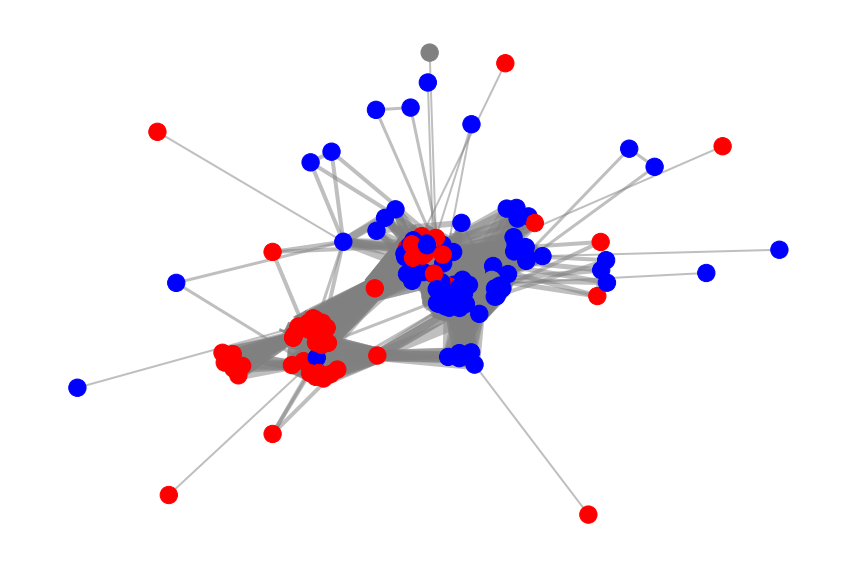

In [56]:
plt.figure(figsize=(12,8))
pos = nx.spring_layout(sub, seed=42) 

# nodes
color = list()
for node in sub.nodes():
    if party[node] == 'D':
        color.append('blue')
    elif party[node] == 'R':
        color.append('red')
    else:
        color.append('grey')
        
nx.draw_networkx_nodes(sub, pos, node_color = color)

# edges
edge_width = [details['weight'] for i, j, details in sub.edges(data=True)]
nx.draw_networkx_edges(sub, pos, width=edge_width, 
                       edge_color='grey', alpha=0.5)


# labels
# nx.draw_networkx_labels(sub, pos, 
#                        font_size=14)

ax = plt.gca()
ax.margins(0.1)
plt.axis("off")
plt.tight_layout()
plt.show()

# Example 3

In [97]:
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from kneed import KneeLocator

In [59]:
filename = 'King_BirminghamJail.txt'

with open(filename, 'r') as fp:
    raw_text = fp.read()
    
# turn into a Spacy document
doc = nlp(raw_text)
print(doc)

"Letter from a Birmingham Jail [King, Jr.]"

16 April 1963
My Dear Fellow Clergymen:
While confined here in the Birmingham city jail, I came across your recent statement calling my present activities "unwise and untimely." Seldom do I pause to answer criticism of my work and ideas. If I sought to answer all the criticisms that cross my desk, my secretaries would have little time for anything other than such correspondence in the course of the day, and I would have no time for constructive work. But since I feel that you are men of genuine good will and that your criticisms are sincerely set forth, I want to try to answer your statement in what I hope will be patient and reasonable terms.

I think I should indicate why I am here in Birmingham, since you have been influenced by the view which argues against "outsiders coming in." I have the honor of serving as president of the Southern Christian Leadership Conference, an organization operating in every southern state, with headquarters i

In [81]:
POS_keep = {'ADJ',
            'ADV',
            'NOUN',
            'PROPN',
            'VERB'}

In [82]:
trimmed = list()

for token in doc:
    if token.pos_ in POS_keep:
        trimmed.append(token)
        
print('Started with {} tokens'.format(len(doc)))
print('Kept {} tokens'.format(len(trimmed)))

unique_words = set([token.lower_ for token in trimmed])
print('{} unique words found'.format(len(unique_words)))

Started with 7817 tokens
Kept 3592 tokens
1737 unique words found


In [83]:
for i, val in enumerate(trimmed):
    print(i, val)

0 Letter
1 Birmingham
2 Jail
3 King
4 Jr.
5 April
6 Dear
7 Fellow
8 Clergymen
9 confined
10 here
11 Birmingham
12 city
13 jail
14 came
15 recent
16 statement
17 calling
18 present
19 activities
20 unwise
21 untimely
22 Seldom
23 pause
24 answer
25 criticism
26 work
27 ideas
28 sought
29 answer
30 criticisms
31 cross
32 desk
33 secretaries
34 have
35 little
36 time
37 other
38 such
39 correspondence
40 course
41 day
42 have
43 time
44 constructive
45 work
46 feel
47 men
48 genuine
49 good
50 will
51 criticisms
52 sincerely
53 set
54 want
55 try
56 answer
57 statement
58 hope
59 be
60 patient
61 reasonable
62 terms
63 think
64 indicate
65 why
66 here
67 Birmingham
68 influenced
69 view
70 argues
71 outsiders
72 coming
73 in
74 have
75 honor
76 serving
77 president
78 Southern
79 Christian
80 Leadership
81 Conference
82 organization
83 operating
84 southern
85 state
86 headquarters
87 Atlanta
88 Georgia
89 have
90 affiliated
91 organizations
92 South
93 is
94 Alabama
95 Christian
96 Movem

962 concoct
963 answer
964 year
965 old
966 son
967 asking
968 Daddy
969 why
970 white
971 people
972 treat
973 colored
974 people
975 so
976 mean
977 when
978 take
979 cross
980 county
981 drive
982 find
983 necessary
984 sleep
985 night
986 night
987 uncomfortable
988 corners
989 automobile
990 motel
991 accept
992 when
993 humiliated
994 day
995 in
996 day
997 nagging
998 signs
999 reading
1000 white
1001 colored
1002 when
1003 first
1004 name
1005 becomes
1006 nigger
1007 middle
1008 name
1009 becomes
1010 boy
1011 however
1012 old
1013 last
1014 name
1015 becomes
1016 John
1017 wife
1018 mother
1019 never
1020 given
1021 respected
1022 title
1023 Mrs.
1024 when
1025 harried
1026 day
1027 haunted
1028 night
1029 fact
1030 are
1031 Negro
1032 living
1033 constantly
1034 tiptoe
1035 stance
1036 never
1037 quite
1038 knowing
1039 expect
1040 next
1041 plagued
1042 inner
1043 fears
1044 outer
1045 resentments
1046 when
1047 forever
1048 fighting
1049 degenerating
1050 sense
1051 nobodi

1962 extreme
1963 first
1964 rather
1965 disappointed
1966 fellow
1967 clergymen
1968 see
1969 nonviolent
1970 efforts
1971 extremist
1972 began
1973 thinking
1974 fact
1975 stand
1976 middle
1977 opposing
1978 forces
1979 Negro
1980 community
1981 force
1982 complacency
1983 made
1984 part
1985 Negroes
1986 result
1987 long
1988 years
1989 oppression
1990 so
1991 drained
1992 self
1993 respect
1994 sense
1995 somebodiness
1996 adjusted
1997 segregation
1998 part
1999 few
2000 middle
2001 class
2002 Negroes
2003 degree
2004 academic
2005 economic
2006 security
2007 ways
2008 profit
2009 segregation
2010 become
2011 insensitive
2012 problems
2013 masses
2014 other
2015 force
2016 bitterness
2017 hatred
2018 comes
2019 perilously
2020 close
2021 advocating
2022 violence
2023 expressed
2024 various
2025 black
2026 nationalist
2027 groups
2028 springing
2029 nation
2030 largest
2031 best
2032 known
2033 being
2034 Elijah
2035 Muhammad
2036 Muslim
2037 movement
2038 Nourished
2039 Negro
204

2961 spirit
2962 early
2963 church
2964 lose
2965 authenticity
2966 loyalty
2967 millions
2968 dismissed
2969 irrelevant
2970 social
2971 club
2972 meaning
2973 twentieth
2974 century
2975 day
2976 meet
2977 young
2978 people
2979 disappointment
2980 church
2981 turned
2982 outright
2983 disgust
2984 Perhaps
2985 once
2986 again
2987 been
2988 too
2989 optimistic
2990 organized
2991 religion
2992 too
2993 inextricably
2994 bound
2995 status
2996 quo
2997 save
2998 nation
2999 world
3000 Perhaps
3001 turn
3002 faith
3003 inner
3004 spiritual
3005 church
3006 church
3007 church
3008 true
3009 ekklesia
3010 hope
3011 world
3012 again
3013 thankful
3014 God
3015 noble
3016 souls
3017 ranks
3018 organized
3019 religion
3020 broken
3021 loose
3022 paralyzing
3023 chains
3024 conformity
3025 joined
3026 active
3027 partners
3028 struggle
3029 freedom
3030 left
3031 secure
3032 congregations
3033 walked
3034 streets
3035 Albany
3036 Georgia
3037 gone
3038 highways
3039 South
3040 tortuous
3041

In [76]:
a = trimmed[2]
b = trimmed[13]

print(a, b)
print('Similarity: ', a.similarity(b))

Birmingham Birmingham
Similarity:  1.0


In [77]:
a = trimmed[13]
b = trimmed[14]

print(a, b)
print('Similarity: ', a.similarity(b))

Birmingham city
Similarity:  0.5404423


<ipython-input-77-17dabdd09abf>:5: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print('Similarity: ', a.similarity(b))


In [84]:
a = trimmed[0]
b = trimmed[1]

print(a, b)
print('Similarity: ', a.similarity(b))

Letter Birmingham
Similarity:  0.13216022


<ipython-input-84-0922953277ca>:5: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  print('Similarity: ', a.similarity(b))


In [88]:
# for each token, how similar is it to all other tokens?
similarities = np.zeros((len(trimmed),
                         len(trimmed)))

for i, token1 in enumerate(trimmed):
    for j, token2 in enumerate(trimmed):
        sim = token1.similarity(token2)
        
        similarities[i][j] = sim
        similarities[j][i] = sim
        
print('All similarities calculated')

<ipython-input-88-40b1eade7bdb>:8: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Token.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  sim = token1.similarity(token2)


All similarities calculated


In [89]:
# now we have a matrix where each row is a token and each column is its similarity to other tokens
similarities

array([[1.        , 0.13216022, 0.30058229, ..., 0.06932937, 0.03065498,
        0.27270436],
       [0.13216022, 1.        , 0.4154714 , ..., 0.46880987, 0.49363872,
        0.13301808],
       [0.30058229, 0.4154714 , 1.        , ..., 0.34999359, 0.15509193,
        0.51393098],
       ...,
       [0.06932937, 0.46880987, 0.34999359, ..., 1.        , 0.62614572,
        0.09043808],
       [0.03065498, 0.49363872, 0.15509193, ..., 0.62614572, 1.        ,
        0.15383714],
       [0.27270436, 0.13301808, 0.51393098, ..., 0.09043808, 0.15383714,
        1.        ]])

In [91]:
print(len(trimmed))
print(np.shape(similarities))

3592
(3592, 3592)


In [120]:
pca = PCA()
pca.fit(similarities)
X = pca.transform(similarities)
print(np.shape(X))

(3592, 3592)


In [131]:
n = 50
print('The first {} dimensions explain {:.2%} of the variance'.format(n, np.sum(pca.explained_variance_ratio_[:n])))

The first 50 dimensions explain 98.81% of the variance


In [132]:
X_reduced = np.matrix([row[:50] for row in X])
print(np.shape(X_reduced))

(3592, 50)


In [93]:
# we'll use k-means clustering to identify which words are similar
# initialize our k-means algorithm

def get_kmeans(k, X):
    kmeans = KMeans(
        n_clusters=k
    )

    # run k-means!
    return kmeans.fit(X)

In [124]:
k = len(unique_words)
kmeans = get_kmeans(k, X_reduced)

In [ ]:
error = list() # save error for this value of k

for k in range(1,len(unique_words)): 
    if k%100 == 0:
        print('Checking k = {}'.format(k))
    kmeans = get_kmeans(k, X_reduced)
    error.append(kmeans.inertia_) # save sum of squared error (SSE)
    
print('{} values of k checked'.format(len(error)))

Checking k = 100
Checking k = 200


In [ ]:
# "Elbow Method" plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(error)+1), error, markersize=10)

plt.xticks(np.arange(0, 21, 1))
plt.title('K-Means: Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Squared Standard Error')
plt.show()

In [ ]:
kl = KneeLocator(range(1, len(error)+1), error, 
                 curve="convex", direction="decreasing")
kl.elbow